Julia Pawluś, Kamil Sarzyniak, Piotr Stawarski

In [2]:
def knapsack(weights, values, capacity):
    n = len(values)
    dp = [[0 for _ in range(capacity + 1)] for _ in range(n + 1)]

    # Wypełnianie tablicy DP
    for i in range(1, n + 1):
        for w in range(capacity + 1):
            if weights[i - 1] <= w:
                dp[i][w] = max(dp[i - 1][w], dp[i - 1][w - weights[i - 1]] + values[i - 1])
            else:
                dp[i][w] = dp[i - 1][w]

    # Odtwarzanie wybranych przedmiotów
    w = capacity
    selected_items = []
    for i in range(n, 0, -1):
        if dp[i][w] != dp[i - 1][w]:
            selected_items.append(i - 1)  # dodajemy indeks przedmiotu
            w -= weights[i - 1]

    selected_items.reverse()  # zachowanie oryginalnej kolejności
    return dp[n][capacity], selected_items

In [3]:
import pandas as pd

data = pd.read_csv('knapsack_5_items.csv')

weights = data['Weights'].apply(lambda x: [int(i) for i in x.strip('[]').split()]).tolist()
values = data['Prices'].apply(lambda x: [int(i) for i in x.strip('[]').split()]).tolist()
capacity = data['Capacity'].tolist()


In [4]:
best_values = []
selected_items = []

for c in range(len(capacity)):
    best_values.append(0)
    selected_items.append([])
    best_values[c], selected_items[c] = knapsack(weights[c], values[c], capacity[c])


In [5]:
# tabela 
tabela = []

for i in range(10):  
    wagi = weights[i]
    wartosci = values[i]
    poj = capacity[i]
    wart_alg = best_values[i]
    wart_best = data['Best price'][i]
    wybrane = selected_items[i]
    zgodnosc = "Tak" if wart_alg == wart_best else "Nie"

    tabela.append({
        'Nr': i + 1,
        'Wagi': wagi,
        'Wartości': wartosci,
        'Pojemność': poj,
        'Wartość algorytmu': wart_alg,
        'Best price': wart_best,
        'Wybrane przedmioty': wybrane,
        'Zgodność': zgodnosc
    })


tabela_df = pd.DataFrame(tabela)
print(tabela_df)


   Nr                  Wagi             Wartości  Pojemność  \
0   1  [46, 40, 42, 38, 10]  [12, 19, 19, 15, 8]         40   
1   2     [11, 31, 4, 6, 7]    [2, 8, 18, 16, 3]         64   
2   3  [32, 49, 27, 37, 24]   [19, 16, 16, 4, 1]         87   
3   4  [20, 35, 22, 23, 16]   [19, 17, 19, 9, 1]         21   
4   5   [7, 12, 19, 13, 20]  [10, 11, 18, 15, 5]         50   
5   6   [27, 10, 25, 25, 7]   [13, 19, 7, 16, 3]         66   
6   7   [21, 2, 33, 45, 26]   [1, 14, 10, 6, 13]         80   
7   8  [37, 27, 39, 14, 25]   [18, 7, 15, 4, 13]         35   
8   9    [1, 48, 4, 23, 39]   [9, 4, 10, 16, 12]         51   
9  10     [4, 3, 22, 9, 32]    [14, 6, 3, 17, 8]         53   

   Wartość algorytmu  Best price Wybrane przedmioty Zgodność  
0                 19        19.0                [1]      Tak  
1                 47        47.0    [0, 1, 2, 3, 4]      Tak  
2                 36        36.0          [0, 2, 4]      Tak  
3                 19        19.0                [0]   

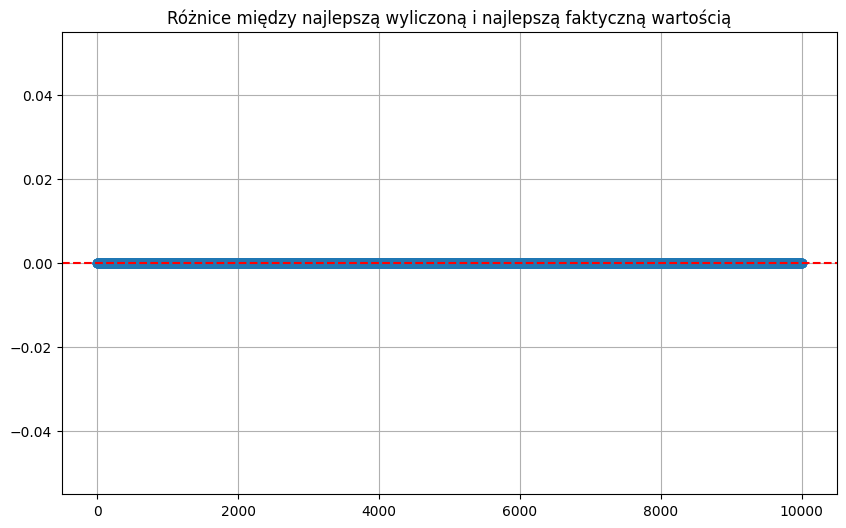

In [6]:
import matplotlib.pyplot as plt

differences = [best_values[i] - data['Best price'][i] for i in range(len(best_values))]

plt.figure(figsize=(10, 6))
plt.plot(range(len(differences)), differences, marker='o', linestyle='-')
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Różnice między najlepszą wyliczoną i najlepszą faktyczną wartością')
plt.grid(True)
plt.show()


Genetic Algorithm for Knapsack

In [75]:
import random

def fitness(individual, weights, values, capacity):
    total_weight = sum(individual[i] * weights[i] for i in range(len(weights)))
    total_value = sum(individual[i] * values[i] for i in range(len(values)))
    if total_weight > capacity:
        return 0
    else:
        return total_value
    

In [76]:
def selection(population, weights, values, capacity):
    k = 3
    selected = random.sample(population, k)
    selected.sort(key=lambda ind: fitness(ind, weights, values, capacity), reverse=True)
    return selected[0]


In [77]:
def crossover(parent1, parent2):
    point = random.randint(1, len(parent1)-1)
    child1 = parent1[:point] + parent2[point:]
    child2 = parent2[:point] + parent1[point:]
    return child1, child2


In [78]:
def mutate(individual, mutation_rate=0.05):
    n = len(individual)
    for i in range(n):
        if random.random() < mutation_rate:
            individual[i] = 1 - individual[i]
    return individual


In [79]:
def knapsack_ga(weights, values, capacity, population_size=50, generations=100, mutation_rate=0.05):
    n = len(weights)
    population = [[random.randint(0,1) for _ in range(n)] for _ in range(population_size)]

    best_individual = None
    best_fitness = 0

    for gen in range(generations):
        new_population = []
        for _ in range(population_size // 2):
            parent1 = selection(population, weights, values, capacity)
            parent2 = selection(population, weights, values, capacity)
            child1, child2 = crossover(parent1, parent2)
            new_population.append(mutate(child1, mutation_rate))
            new_population.append(mutate(child2, mutation_rate))
        population = new_population

        for individual in population:
            fit = fitness(individual, weights, values, capacity)
            if fit > best_fitness:
                best_fitness = fit
                best_individual = individual

    if best_individual is None:
        best_individual = [0]*n
        best_fitness = 0

    selected_items = [i for i in range(n) if best_individual[i] == 1]
    return best_fitness, selected_items

In [80]:
data = pd.read_csv('knapsack_5_items.csv')

weights = data['Weights'].apply(lambda x: [int(i) for i in x.strip('[]').split()]).tolist()
values = data['Prices'].apply(lambda x: [int(i) for i in x.strip('[]').split()]).tolist()
capacity = data['Capacity'].tolist()


In [81]:
best_values_ga = []
selected_items_ga = []

for c in range(len(capacity)):
    best_val, selected = knapsack_ga(weights[c], values[c], capacity[c])
    best_values_ga.append(best_val)
    selected_items_ga.append(selected)


In [82]:
tabela_ga = []

for i in range(10):
    wagi = weights[i]
    wartosci = values[i]
    poj = capacity[i]
    wart_alg = best_values_ga[i]
    wart_best = data['Best price'][i]
    wybrane = selected_items_ga[i]
    zgodnosc = "Tak" if wart_alg == wart_best else "Nie"

    tabela_ga.append({
        'Nr': i + 1,
        'Wagi': wagi,
        'Wartości': wartosci,
        'Pojemność': poj,
        'Wartość GA': wart_alg,
        'Best price': wart_best,
        'Wybrane przedmioty': wybrane,
        'Zgodność': zgodnosc
    })

tabela_ga_df = pd.DataFrame(tabela_ga)
print(tabela_ga_df)


   Nr                  Wagi             Wartości  Pojemność  Wartość GA  \
0   1  [46, 40, 42, 38, 10]  [12, 19, 19, 15, 8]         40          19   
1   2     [11, 31, 4, 6, 7]    [2, 8, 18, 16, 3]         64          47   
2   3  [32, 49, 27, 37, 24]   [19, 16, 16, 4, 1]         87          36   
3   4  [20, 35, 22, 23, 16]   [19, 17, 19, 9, 1]         21          19   
4   5   [7, 12, 19, 13, 20]  [10, 11, 18, 15, 5]         50          44   
5   6   [27, 10, 25, 25, 7]   [13, 19, 7, 16, 3]         66          48   
6   7   [21, 2, 33, 45, 26]   [1, 14, 10, 6, 13]         80          37   
7   8  [37, 27, 39, 14, 25]   [18, 7, 15, 4, 13]         35          13   
8   9    [1, 48, 4, 23, 39]   [9, 4, 10, 16, 12]         51          35   
9  10     [4, 3, 22, 9, 32]    [14, 6, 3, 17, 8]         53          45   

   Best price Wybrane przedmioty Zgodność  
0        19.0                [1]      Tak  
1        47.0    [0, 1, 2, 3, 4]      Tak  
2        36.0          [0, 2, 4]      Tak 

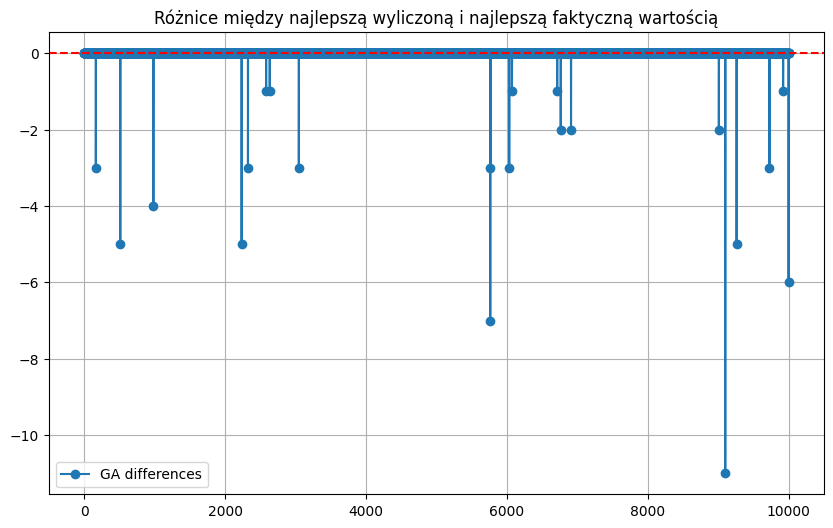

In [83]:

differences_ga = [best_values_ga[i] - data['Best price'][i] for i in range(len(best_values_ga))]

plt.figure(figsize=(10, 6))
plt.plot(range(len(differences_ga)), differences_ga, marker='o', linestyle='-', label='GA differences')
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Różnice między najlepszą wyliczoną i najlepszą faktyczną wartością')
plt.grid(True)
plt.legend()
plt.show()
